# Camera and laser triggering analysis

In this notebook, we generate the figures related to the camera and laser triggering. In order to download the data, run the [download_data notebook](0_download_data.ipynb) first. 

The data comes as \*.txt files generated by a Teledyne Lecroy LECROYHDO4054 oscilloscope, and were acquired using the python scripts found in the [MicroFPGA-py repository](https://github.com/mufpga/MicroFPGA-py/tree/main/examples/figures). In passive synchronization, the FPGA was receiving the camera exposure signal generated by an Andor iXon Ultra 897 camera controlled using Micro-Manager. The laser trigger signals and the fire signal (in active mode) were directly measured with the Oscilloscope. The FPGA was housed in a complete electronic box and connected to other devices at the same time.

In [1]:
import os, re
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# define some matplotlib style for all figures
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [2]:
def load_single(path):
    '''
    Load a single file and return a 2D list (time, value).
    '''
    with open(path) as f:
        lines = f.readlines()[5:]    
        v = np.zeros((len(lines), 2))
    
        for i in range(len(lines)):
            split = lines[i].split('\t')
            v[i,0] = float(split[0])
            v[i,1] = float(split[1])
    
        return v
    
def load_all(path):
    '''
    Load all *.txt files contained in path and returns a list of 2D lists (time, value).
    '''
    vals_list = []
    f_list = [f for f in os.listdir(path) if f.endswith('.txt')]
    
    if path.endswith(os.path.sep):
        new_path = path
    else:
        new_path = path+os.path.sep
    
    for f in f_list:
        vals_list.append(load_single(new_path+f))
        
    return vals_list
    
    
def plot_wide(ref, v_list, time_scale = 1):
    '''
    Plot all elements (time, value) of v_list in a wide plot. time_scale allows changing the unit of the x-axis.
    '''
    plt.figure(figsize=(15, 3))
    plt.plot(ref[:,0]*time_scale,ref[:,1])
    plt.plot([ref[0,0]*time_scale, ref[-1,0]*time_scale], [2, 2])
    for v in v_list:
        plt.plot(v[:,0]*time_scale,v[:,1])
    plt.show()
    
def plot_multichannel(ref, v_list, time_scale = 1):
    '''
    Plot all elements (time, value) contained in the various lists of v_list. 
    time_scale allows changing the unit of the x-axis.
    '''
    plt.figure()
    plt.plot(ref[:,0]*time_scale,ref[:,1])
    plt.plot([ref[0,0]*time_scale, ref[-1,0]*time_scale], [2, 2])
    for ch in v_list:
        for v in ch:
            plt.plot(v[:,0]*time_scale,v[:,1])
    plt.show()
    
def get_delays(v_list, threshold = 2, inverted = False):
    '''
    Return the first time point at which each element of v_list crosses the threshold 
    from smaller values.
    '''
    ds = []
    
    for v in v_list:
        t = v[get_delay_index(v, threshold), 0]
              
        ds.append(t)
    
    return np.array(ds)
    
def get_delay_index(v, threshold = 2):
    return np.argmax(v[:,1] > threshold)

# Conveniance methods to set the x-axis title
def s():
    return 'time (s)'

def ms():
    return 'time (ms)'

def us():
    return 'time (\u03bcs)'

def ns():
    return 'time (ns)'


timing = {1 : s,
          1_000 : ms,
          1_000_000 : us,
          1_000_000_000 : ns
}

def get_time(time_scale):
    return timing[time_scale]()


# Passive mode: laser triggering

## Panel a: pulsing delay
MicroFPGA parameters set according to the [fig_passive_a](https://github.com/mufpga/MicroFPGA-py/blob/main/examples/figures/fig_laser_passive_a.py) python script.

In [3]:
# load data
root  = op.join('data','triggering','passive_delay')
cam = load_single(op.join(root,'C1_00000.txt'))
all_vals = load_all(op.join(root,'ch2'))
print(f'Number of measurements: {len(all_vals)}')

Number of measurements: 203


In [4]:
# voltage(t0)=2 might not be exactly at t0 = 0s. Even though the value is expected to be quite small, 
# we compute it here
ind = get_delay_index(cam, 2)
t0 = cam[ind, 0]
print(f'Crossing time {t0} s, voltage(t0-1)={cam[ind-1,1]} and voltage(t0)={cam[ind,1]}')

Crossing time -2.49973e-09 s, voltage(t0-1)=1.892 and voltage(t0)=2.004


In [5]:
# compute delay for all laser signals
delays = (get_delays(all_vals)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays)} +/- {np.std(delays)} ns')
print(f'Min delay {np.min(delays)}, Median {np.median(delays)}, Max delay {np.max(delays)}')

Delay 58.41835019704435 +/- 2.7370273528019715 ns
Min delay 53.66033, Median 58.46143, Max delay 63.617630000000005


indices: [177, 45, 143]


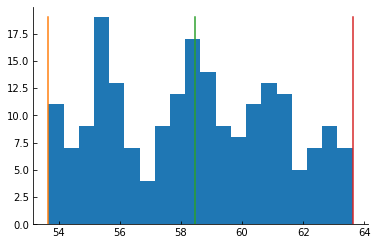

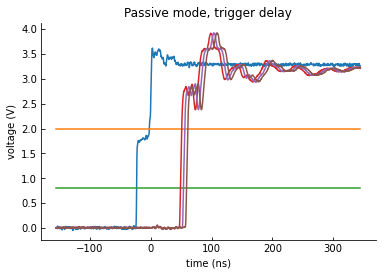

In [6]:
# Plot the camera exposure signal and the min/median/max delayed laser trigger signals
def plot_histo(vals, vertical):
    '''
    Plot an histogram with vertical lines.
    '''
    y, x, _ = plt.hist(vals, bins = 20, density=False)
    
    for v in vertical:
        plt.plot([v, v], [0, max(y)])
    
    plt.show()
    
def plot_panel_a(ref, v_list, time_scale = 1):
    '''
    Plot figure panel a.
    '''
    plt.figure()
    plt.plot(ref[:,0]*time_scale,ref[:,1]) # camera
    plt.plot([ref[0,0]*time_scale, ref[-1,0]*time_scale], [2, 2]) # HIGH threshold
    plt.plot([ref[0,0]*time_scale, ref[-1,0]*time_scale], [0.8, 0.8]) # LOW threshold
    for v in v_list:
        plt.plot(v[:,0]*time_scale,v[:,1]) # lasers   
        
    plt.title('Passive mode, trigger delay')
    plt.xlabel(get_time(time_scale))
    plt.ylabel('voltage (V)')
    #plt.xlim(-50,150)
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_passive_a.eps'), format='eps')

# get the indices of the min/median/max delayed signals
i_s = [np.argmax(delays == np.min(delays)),
       np.argmin(abs(delays - np.median(delays))),
       np.argmax(delays == np.max(delays))]
vals = [all_vals[i] for i in i_s]
print(f'indices: {i_s}')

# sanity check: the median, min and max delays really are so (colors will be different from the next plot)
plot_histo(delays, delays[i_s]) 

# plot the min/median/max delayed signals with the x-axis in ns 
plot_panel_a(cam, vals, time_scale = 1_000_000_000)

## Panel b: pulse length precision


MicroFPGA parameters set according to the [fig_passive_b](https://github.com/mufpga/MicroFPGA-py/blob/main/examples/figures/fig_laser_passive_b.py) python script.

In [7]:
# load data
root  = op.join('data','triggering','passive_pulse')
cam = load_single(op.join(root,'C1_00000.txt'))
ch2 = load_all(op.join(root,'ch2'))
ch3 = load_all(op.join(root,'ch3'))
ch4 = load_all(op.join(root,'ch4'))
print(f'Number of samples: {len(ch2)}')

Number of samples: 205


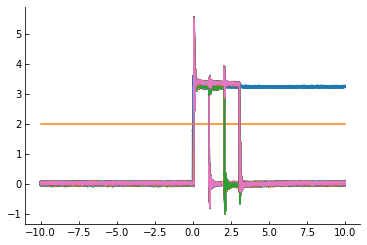

In [8]:
# show data
plot_multichannel(cam, [ch2, ch3, ch4], time_scale = 1_000_000)

In [9]:
# compute t0: the moment the camera exposure signal crosses the threshold
ind = get_delay_index(cam, 2)
t0 = cam[ind, 0]
print(f'Crossing time {t0} s, voltage(t0-1)={cam[ind-1,1]} and voltage(t0)={cam[ind,1]}')

Crossing time -2.4444735e-09 s, voltage(t0-1)=1.904 and voltage(t0)=2.02


In [10]:
# compute delay
delays_ch2 = (get_delays(ch2)-t0)*1_000_000_000  # to ns
print(f'1 us pulse: delay {np.mean(delays_ch2)} +/- {np.std(delays_ch2)} ns')
print(f'Min delay {np.min(delays_ch2)}, Median {np.median(delays_ch2)}, Max delay {np.max(delays_ch2)}\n')

# compute delay
delays_ch3 = (get_delays(ch3)-t0)*1_000_000_000  # to ns
print(f'2 us pulse: delay {np.mean(delays_ch3)} +/- {np.std(delays_ch3)} ns')
print(f'Min delay {np.min(delays_ch3)}, Median {np.median(delays_ch3)}, Max delay {np.max(delays_ch3)}\n')

# compute delay
delays_ch4 = (get_delays(ch4)-t0)*1_000_000_000  # to ns
print(f'3 us pulse: delay {np.mean(delays_ch4)} +/- {np.std(delays_ch4)} ns')
print(f'Min delay {np.min(delays_ch4)}, Median {np.median(delays_ch4)}, Max delay {np.max(delays_ch4)}')

1 us pulse: delay 69.6815074609756 +/- 2.907527658661275 ns
Min delay 64.6484715, Median 69.63839150000001, Max delay 74.9000415

2 us pulse: delay 71.9575978277027 +/- 2.8586135427939414 ns
Min delay 66.77733950000001, Median 72.0997645, Max delay 77.0189755

3 us pulse: delay 63.73766096078432 +/- 2.8669026366426578 ns
Min delay 58.917063500000005, Median 63.8191815, Max delay 68.7698025


In [11]:
# compute average delay
def get_pulse_length(laser):

    t0 = []
    t1 = []
    for v in laser:
        for i in range(len(v)-1):
            if v[i,1] <= 2 < v[i+1,1]:
                    t0.append(v[i, 0])

            if v[i,1] >= 2 > v[i+1,1]:
                    t1.append(v[i, 0])
        
        assert len(t0) == len(t1)
        
    pulses = np.array([t1[i]-t0[i] for i in range(len(t1))])*1_000_000
        
    return pulses

t_ch2 = get_pulse_length(ch2)
t_ch3 = get_pulse_length(ch3)
t_ch4 = get_pulse_length(ch4)

print(f'Pulse ch2 {np.mean(t_ch2)} +/- {np.std(t_ch2)} us')
print(f'Pulse ch3 {np.mean(t_ch3)} +/- {np.std(t_ch3)} us')
print(f'Pulse ch4 {np.mean(t_ch4)} +/- {np.std(t_ch4)} us')

Pulse ch2 0.9983434172585366 +/- 0.00017423875432150858 us
Pulse ch3 1.9960810800641893 +/- 0.00019149022888805776 us
Pulse ch4 2.998850978715686 +/- 0.00019938275033233157 us


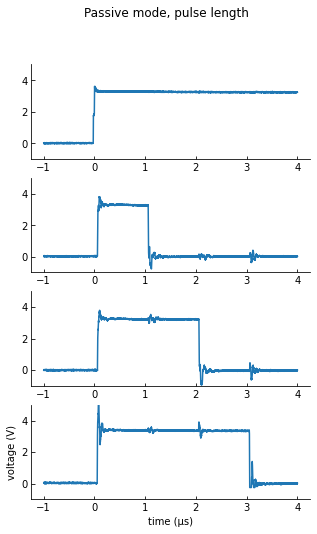

In [12]:
# plot figure panel b using the median
def plot_panel_b(ref, v_list, xrange, time_scale = 1):
    '''
    Plot figure panel b.
    '''
    tmin = xrange[0]
    tmax = xrange[1]
    rnge = [-1, 5]
    
    fig, ax = plt.subplots(len(v_list)+1, figsize=(5,8))
    ax[0].plot((ref[tmin:tmax,0]-t0)*time_scale,ref[tmin:tmax,1]) # camera
    ax[0].set_ylim(rnge)
    
    for i, v in enumerate(v_list):
        ax[i+1].plot((v[tmin:tmax,0]-t0)*time_scale,v[tmin:tmax,1]) # lasers 
        ax[i+1].set_ylim(rnge)
        
    fig.suptitle('Passive mode, pulse length')
    ax[-1].set_xlabel(get_time(time_scale))
    ax[-1].set_ylabel('voltage (V)')
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_passive_b.eps'), format='eps')

# get range -1 us to 4 us
tmin = np.argmax(cam[:,0] >= -1e-6)
tmax = np.argmax(cam[:,0] >= 4e-6)
    
    
# get the indices of the median delayed signals
i_ch2 = np.argmin(abs(delays_ch2 - np.median(delays)))
i_ch3 = np.argmin(abs(delays_ch3 - np.median(delays)))
i_ch4 = np.argmin(abs(delays_ch4 - np.median(delays)))

vals = [ch2[i_ch2],ch3[i_ch3],ch4[i_ch4]]

# plot the median delayed signals with the x-axis in us 
plot_panel_b(cam, vals, [tmin, tmax], time_scale = 1_000_000)

## Panel c: illustrate sequence


MicroFPGA parameters set according to the [fig_passive_c](https://github.com/mufpga/MicroFPGA-py/blob/main/examples/figures/fig_laser_passive_c.py) python script.

In [13]:
# load data
root = op.join('data','triggering','passive_sequence')
cam = load_single(op.join(root,'C1_00000.txt'))
ch2 = load_single(op.join(root,'C2_00000.txt'))
ch3 = load_single(op.join(root,'C3_00000.txt'))
ch4 = load_single(op.join(root,'C4_00000.txt'))

In [14]:
def count_frames(ref):
    '''
    Count the number of camera frames.
    '''
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] <= 2 < ref[i+1,1]:
            counter += 1
            
    return counter

def find_rising(ref, n = 1):
    '''
    Find n-th rising edge.
    '''
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] <= 2 < ref[i+1,1]:
            counter += 1
            if counter == n:
                return i 
        
    return -1

def find_falling(ref, n = 1):
    '''
    Find n-th falling edge.
    '''
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] >= 2 > ref[i+1,1]:
            counter += 1
            if counter == n:
                return i 
        
    return -1


In [15]:
# count the number of camera frames and of full 16-frame long sequences
n_frames = count_frames(cam)
print(f'Total number of frames: {n_frames}')
print(f'Number of full sequences: {int(n_frames / 16)}')

Total number of frames: 69
Number of full sequences: 4


Frame length: 1000.0 +/- 0.0 points
Inter-frame length: 467.76119402985074 +/- 25.45472395663762 points


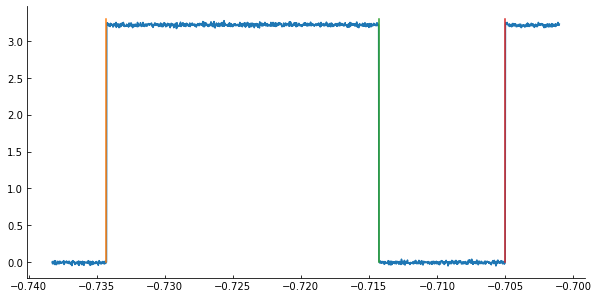

In [16]:
# calculate frame and sequence sizes
len_frame_l = []
inter_frame_l = []

for i in range(1,68):
    i_fr = find_rising(cam, i)
    i_sr = find_rising(cam, i+1)
    i_ff = find_falling(cam, i)

    # plot an example
    if i == 10:
        plt.figure(figsize=(10, 5))
        plt.plot(cam[max(0, i_fr-200):min(len(cam),i_sr+200),0], cam[max(0, i_fr-200):min(len(cam),i_sr+200),1])
        for i in (i_fr, i_ff, i_sr):
            plt.plot([cam[i,0], cam[i,0]], [0, 3.3])

    if i == 1:
        offset = i_fr

    len_frame_l.append(i_ff-i_fr)
    inter_frame_l.append(i_sr-i_ff)
    
inter_frame = int(np.mean(inter_frame_l))
print(f'Frame length: {np.mean(len_frame_l)} +/- {np.std(len_frame_l)} points')
print(f'Inter-frame length: {np.mean(inter_frame_l)} +/- {np.std(inter_frame_l)} points')

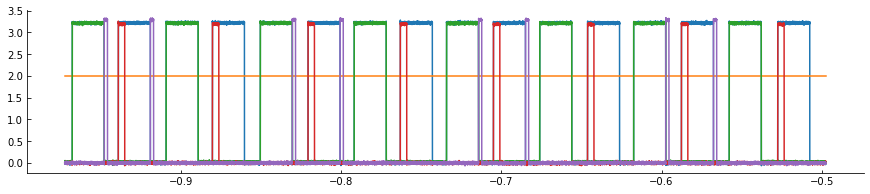

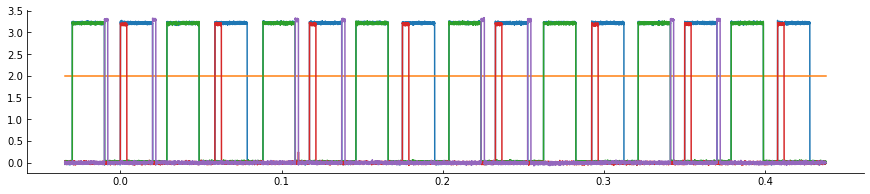

(48276, 71882)

In [17]:
# let's look at serveral sequences
def get_sequence(cam, ch2, ch3, ch4, start_frame = 1, plot = True):
    '''
    Plot the mth single sequence
    '''
    first_pt = max(0, find_rising(cam, start_frame)-int(inter_frame/2) )
    last_pt = min(len(cam), find_rising(cam, start_frame+16) )

    if plot:
        plot_wide(cam[first_pt:last_pt,:], 
              [ch2[first_pt:last_pt,:], 
               ch3[first_pt:last_pt,:], 
               ch4[first_pt:last_pt,:]])
    
    return first_pt, last_pt

# since the first frame is randomly positioned in the sequence, looking at the 4th channel we see
# that the first synchronised sequence start at frame number 2 (ch4 = 1100110011001100)
get_sequence(cam, ch2, ch3, ch4, 2)
get_sequence(cam, ch2, ch3, ch4, 34)

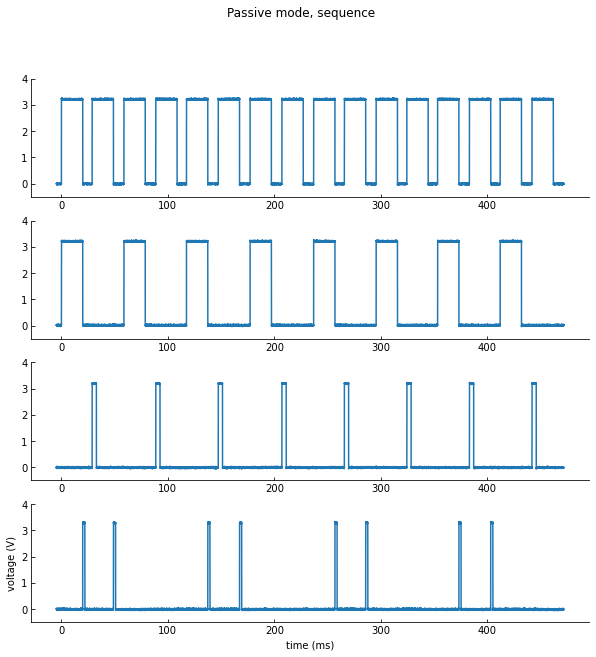

In [18]:
# plot each channels in their own graph
def plot_panel_c(ref, v_list, time_scale = 1):
    rng = [-0.5, 4]
    
    tmin = ref[find_rising(ref),0]
    
    fig, ax = plt.subplots(len(v_list)+1, figsize=(10, 10))
    ax[0].plot((ref[:,0]-tmin)*time_scale,ref[:,1]) # camera
    ax[0].set_ylim(rng)
    
    for i, v in enumerate(v_list):
        ax[i+1].plot((v[:,0]-tmin)*time_scale,v[:,1]) # lasers 
        ax[i+1].set_ylim(rng)
        
    fig.suptitle('Passive mode, sequence')
    ax[-1].set_xlabel(get_time(time_scale))
    ax[-1].set_ylabel('voltage (V)')
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_passive_c.eps'), format='eps')
    

f, l = get_sequence(cam, ch2, ch3, ch4, 50, plot = False)
plot_panel_c(cam[f:l,:], 
          [ch2[f:l,:], 
           ch3[f:l,:], 
           ch4[f:l,:]], time_scale = 1_000)

# Active mode: camera and laser triggering

## Figure active parameters

MicroFPGA parameters set according to the [fig_cam_active](https://github.com/mufpga/MicroFPGA-py/blob/main/examples/figures/fig_cam_active.py) python script.

In [19]:
# load data
root = op.join('data','triggering','active_parameters')
cam = load_single(op.join(root,'C1_00000.txt'))
ch2 = load_single(op.join(root,'C2_00000.txt'))
ch3 = load_single(op.join(root,'C3_00000.txt'))
ch4 = load_single(op.join(root,'C4_00000.txt'))

# count frames
n_frames = count_frames(cam)
print(f'Total number of frames: {n_frames}')
print(f'Number of full sequences: {int(n_frames / 16)}')

Total number of frames: 159
Number of full sequences: 9


Frame length: 750.0 +/- 0.0 points
Inter-frame length: 5500.0 +/- 0.0 points


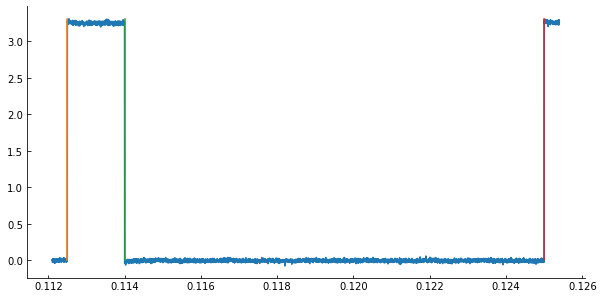

In [20]:
# calculate frame and sequence sizes
len_frame_l = []
inter_frame_l = []

for i in range(1,68):
    i_fr = find_rising(cam, i)
    i_sr = find_rising(cam, i+1)
    i_ff = find_falling(cam, i)

    # plot an example
    if i == 10:
        plt.figure(figsize=(10, 5))
        plt.plot(cam[max(0, i_fr-200):min(len(cam),i_sr+200),0], cam[max(0, i_fr-200):min(len(cam),i_sr+200),1])
        for i in (i_fr, i_ff, i_sr):
            plt.plot([cam[i,0], cam[i,0]], [0, 3.3])

    if i == 1:
        offset = i_fr

    len_frame_l.append(i_ff-i_fr)
    inter_frame_l.append(i_sr-i_ff)
    
length_frame = int(np.mean(len_frame_l))
inter_frame = int(np.mean(inter_frame_l))
print(f'Frame length: {np.mean(len_frame_l)} +/- {np.std(len_frame_l)} points')
print(f'Inter-frame length: {np.mean(inter_frame_l)} +/- {np.std(inter_frame_l)} points')

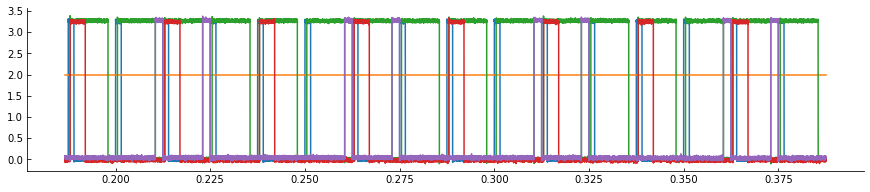

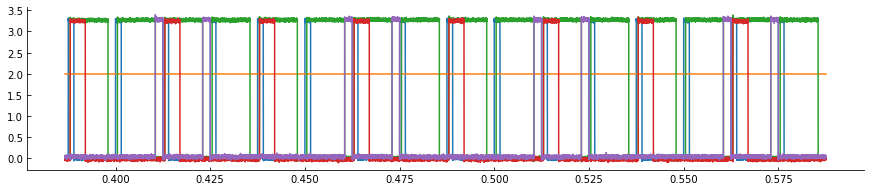

(203292, 303750)

In [21]:
# let's look at several sequences
def get_sequence_active(cam, ch2, ch3, ch4, start_frame = 1, plot = True):
    '''
    Plot the mth single sequence
    '''
    first_pt = max(0, find_rising(cam, start_frame)-int(inter_frame/12) )
    last_pt = min(len(cam), find_rising(cam, start_frame+16) )

    if plot:
        plot_wide(cam[first_pt:last_pt,:], 
              [ch2[first_pt:last_pt,:], 
               ch3[first_pt:last_pt,:], 
               ch4[first_pt:last_pt,:]])
    
    return first_pt, last_pt

get_sequence_active(cam, ch2, ch3, ch4, 16)
get_sequence_active(cam, ch2, ch3, ch4, 32)

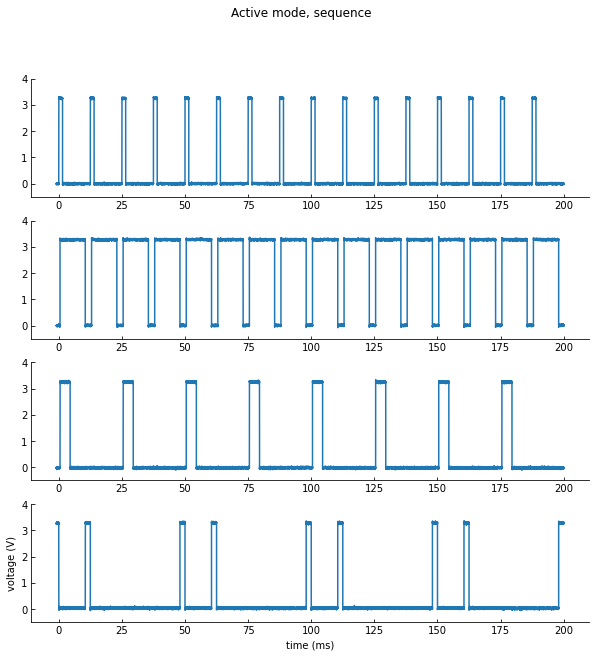

In [22]:
# plot each channels of a single sequence in their own graph
def plot_active_seq(ref, v_list, time_scale = 1):
    rng = [-0.5, 4]
    
    tmin = ref[find_rising(ref),0]
    
    fig, ax = plt.subplots(len(v_list)+1, figsize=(10, 10))
    ax[0].plot((ref[:,0]-tmin)*time_scale,ref[:,1]) # camera
    ax[0].set_ylim(rng)
    
    for i, v in enumerate(v_list):
        ax[i+1].plot((v[:,0]-tmin)*time_scale,v[:,1]) # lasers 
        ax[i+1].set_ylim(rng)
        
    fig.suptitle('Active mode, sequence')
    ax[-1].set_xlabel(get_time(time_scale))
    ax[-1].set_ylabel('voltage (V)')
        
# note that the pulses in ch4 do not start before the camera pulse, but are in falling mode (therefore 
# pulsing before the camera)
f, l = get_sequence_active(cam, ch2, ch3, ch4, 34, plot = False)
plot_active_seq(cam[f:l,:], 
          [ch2[f:l,:], 
           ch3[f:l,:], 
           ch4[f:l,:]], 1_000)

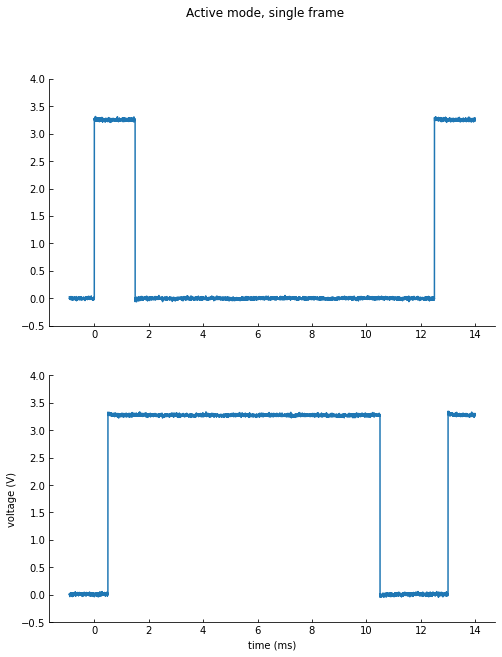

In [23]:
def get_two_frames(cam, ch2, ch3, ch4, start_frame = 1, plot = True):
    '''
    Plot the mth single sequence
    '''
    first_pt = max(0, find_rising(cam, start_frame)-int(inter_frame/12) )
    last_pt = min(len(cam), find_falling(cam, start_frame+1) )

    if plot:
        plot_wide(cam[first_pt:last_pt,:], 
              [ch2[first_pt:last_pt,:], 
               ch3[first_pt:last_pt,:], 
               ch4[first_pt:last_pt,:]])
    
    return first_pt, last_pt

def plot_cam_active(ref, v_list, time_scale = 1):
    rng = [-0.5, 4]
    
    tmin = ref[find_rising(ref),0]
    
    fig, ax = plt.subplots(len(v_list)+1, figsize=(8, 10))
    ax[0].plot((ref[:,0]-tmin)*time_scale,ref[:,1]) # camera
    ax[0].set_ylim(rng)
    
    for i, v in enumerate(v_list):
        ax[i+1].plot((v[:,0]-tmin)*time_scale,v[:,1]) # lasers 
        ax[i+1].set_ylim(rng)
        
    fig.suptitle('Active mode, single frame')
    ax[-1].set_xlabel(get_time(time_scale))
    ax[-1].set_ylabel('voltage (V)')
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_active_parameters.eps'), format='eps')
    
f, l = get_two_frames(cam, ch2, ch3, ch4, start_frame = 50, plot = False)
plot_cam_active(cam[f:l,:], 
          [ch2[f:l,:]], 1_000)

In [24]:
# compute average camera trigger parameters
def get_camera_delay(camera, laser):

    t0 = []
    t1 = []
    t0_f = []
    t1_f = []
    for i in range(len(camera)-1):
        if camera[i,1] <= 2 < camera[i+1,1]:
                t0.append(camera[i, 0])
        
        if laser[i,1] <= 2 < laser[i+1,1]:
                t1.append(laser[i, 0])
                
        if camera[i,1] >= 2 > camera[i+1,1]:
                t0_f.append(laser[i, 0])
                
        if laser[i,1] >= 2 > laser[i+1,1]:
                t1_f.append(laser[i, 0])
        
    assert len(t0) == len(t1)
    assert len(t0) == len(t0_f)

    # bad luck, but the recording ends before the final falling edge of the last pulse
    t1 = t1[:-1]
    assert len(t1) == len(t1_f)
        
    delays = np.array([t1[i]-t0[i] for i in range(len(t1))])*1_000_000
    expo = np.array([t1_f[i]-t1[i] for i in range(len(t1))])*1_000_000
    pulse = np.array([t0_f[i]-t0[i] for i in range(len(t0))])*1_000_000
    readout = np.array([t0[i+1]-t0[i]-t1_f[i]+t1[i]-t0_f[i]+t0[i] for i in range(len(t0)-1)])*1_000_000
        
    return delays, expo, pulse, readout

t_delays, t_expo, t_pulse, t_readout = get_camera_delay(cam, ch2)

print(f'N = {len(t_delays)}')
print(f'Delay {np.mean(t_delays)} +/- {np.std(t_delays)} us')
print(f'Exposure {np.mean(t_expo)} +/- {np.std(t_expo)} us')
print(f'Pulse {np.mean(t_pulse)} +/- {np.std(t_pulse)} us')
print(f'Read-out {np.mean(t_readout)} +/- {np.std(t_readout)} us')

N = 158
Delay 499.7883667460679 +/- 0.6779658128028604 us
Exposure 9999.987341772157 +/- 0.15860714033532108 us
Pulse 1499.5225279615067 +/- 0.002512591612066288 us
Read-out 1000.4774582278446 +/- 0.22503158067920323 us



## Figure active triggering: sequence

MicroFPGA parameters set according to the [fig_active_c](https://github.com/mufpga/MicroFPGA-py/blob/main/examples/figures/fig_laser_active_c.py) python script.

In [25]:
# load data
root = op.join('data','triggering','active_sequence')
cam = load_single(op.join(root,'C1_00000.txt'))
ch2 = load_single(op.join(root,'C2_00000.txt'))
ch3 = load_single(op.join(root,'C3_00000.txt'))
ch4 = load_single(op.join(root,'C4_00000.txt'))

# count number of frames
n_frames = count_frames(cam)
print(f'Total number of frames: {n_frames}')
print(f'Number of full sequences: {int(n_frames / 16)}')

Total number of frames: 81
Number of full sequences: 5


Frame length: 75.0 +/- 0.0 points
Inter-frame length: 550.0 +/- 0.0 points


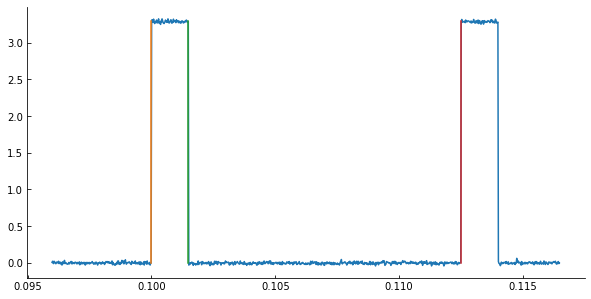

In [26]:
# calculate frame and sequence sizes
len_frame_l = []
inter_frame_l = []

for i in range(1,68):
    i_fr = find_rising(cam, i)
    i_sr = find_rising(cam, i+1)
    i_ff = find_falling(cam, i)

    # plot an example
    if i == 10:
        plt.figure(figsize=(10, 5))
        plt.plot(cam[max(0, i_fr-200):min(len(cam),i_sr+200),0], cam[max(0, i_fr-200):min(len(cam),i_sr+200),1])
        for i in (i_fr, i_ff, i_sr):
            plt.plot([cam[i,0], cam[i,0]], [0, 3.3])

    if i == 1:
        offset = i_fr

    len_frame_l.append(i_ff-i_fr)
    inter_frame_l.append(i_sr-i_ff)
    
length_frame = int(np.mean(len_frame_l))
inter_frame = int(np.mean(inter_frame_l))
print(f'Frame length: {np.mean(len_frame_l)} +/- {np.std(len_frame_l)} points')
print(f'Inter-frame length: {np.mean(inter_frame_l)} +/- {np.std(inter_frame_l)} points')

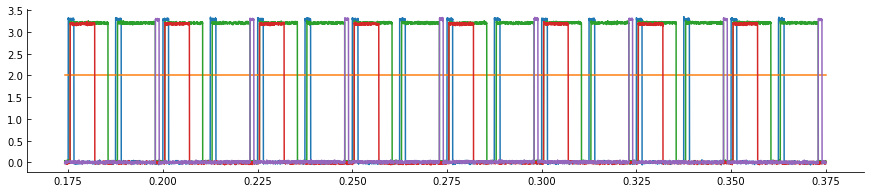

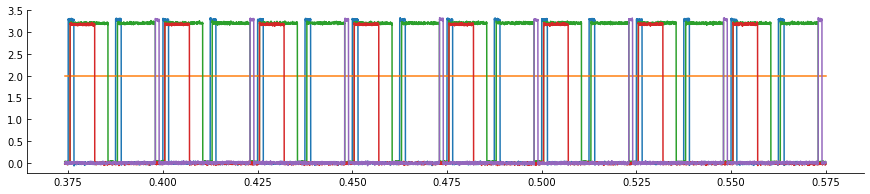

(41905, 51950)

In [27]:
# let's look at several sequences
def get_sequence_active(cam, ch2, ch3, ch4, start_frame = 1, plot = True):
    '''
    Plot the mth single sequence
    '''
    first_pt = max(0, find_rising(cam, start_frame)-int(inter_frame/12) )
    last_pt = min(len(cam), find_rising(cam, start_frame+16) )

    if plot:
        plot_wide(cam[first_pt:last_pt,:], 
              [ch2[first_pt:last_pt,:], 
               ch3[first_pt:last_pt,:], 
               ch4[first_pt:last_pt,:]])
    
    return first_pt, last_pt

get_sequence_active(cam, ch2, ch3, ch4, 16)
get_sequence_active(cam, ch2, ch3, ch4, 32)

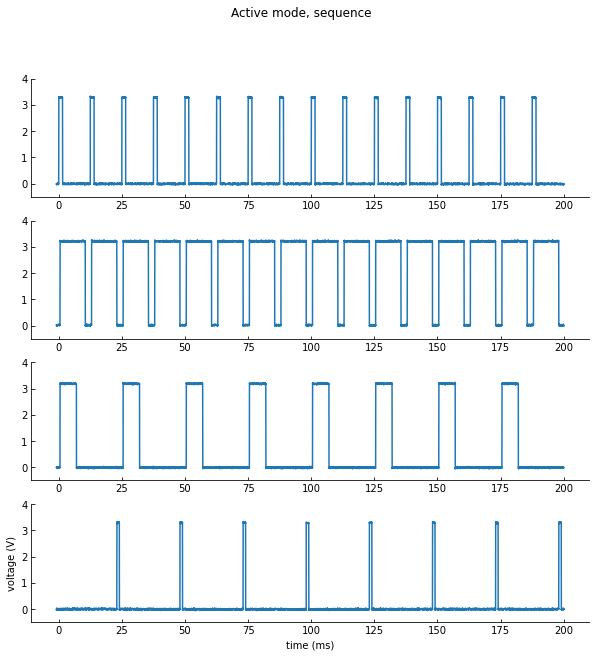

In [28]:
# plot each channels of a single sequence in their own graph
def plot_active_c(ref, v_list, time_scale = 1):
    rng = [-0.5, 4]
    
    tmin = ref[find_rising(ref),0]
    
    fig, ax = plt.subplots(len(v_list)+1, figsize=(10, 10))
    ax[0].plot((ref[:,0]-tmin)*time_scale,ref[:,1]) # camera
    ax[0].set_ylim(rng)
    
    for i, v in enumerate(v_list):
        ax[i+1].plot((v[:,0]-tmin)*time_scale,v[:,1]) # lasers 
        ax[i+1].set_ylim(rng)
        
    fig.suptitle('Active mode, sequence')
    ax[-1].set_xlabel(get_time(time_scale))
    ax[-1].set_ylabel('voltage (V)')
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_active_c.eps'), format='eps')
    
f, l = get_sequence_active(cam, ch2, ch3, ch4, 34, plot = False)
plot_active_c(cam[f:l,:], 
          [ch2[f:l,:], 
           ch3[f:l,:], 
           ch4[f:l,:]], 1_000)

## Panel a: pulsing delay

MicroFPGA parameters set according to the [fig_active_a](https://github.com/mufpga/MicroFPGA-py/blob/main/examples/figures/fig_laser_active_a.py) python script.

In [29]:
# load data
root = op.join('data','triggering','active_delay')
cam = load_single(op.join(root,'C1_00000.txt'))
all_vals = load_all(op.join(root,'ch2'))
print(f'Number of measurements: {len(all_vals)}')

Number of measurements: 232


In [30]:
# voltage(t0)=2 might not be exactly at t0 = 0s. Even though the value is expected to be quite small, 
# we compute it here
ind = get_delay_index(cam, 2)
t0 = cam[ind, 0]
print(f'Crossing time {t0} s, voltage(t0-1)={cam[ind-1,1]} and voltage(t0)={cam[ind,1]}')

Crossing time -1.210547e-10 s, voltage(t0-1)=1.992 and voltage(t0)=2.176


In [31]:
# compute delay
delays = (get_delays(all_vals)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays)} +/- {np.std(delays)} ns')
print(f'Min delay {np.min(delays)}, Max delay {np.max(delays)}, Median {np.median(delays)}')

Delay 54.32191047586207 +/- 0.16923160082923502 ns
Min delay 53.944734700000005, Max delay 54.718144699999996, Median 54.3122997


indices: [52, 209, 69]


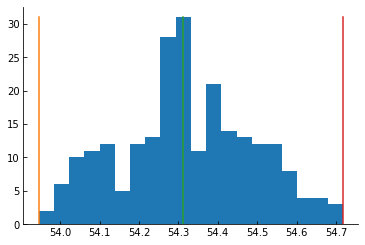

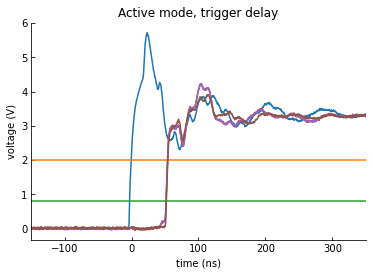

In [32]:
# Plot the camera exposure signal and the min/median/max delayed laser trigger signals
def plot_active_a(ref, v_list, time_scale = 1):
    '''
    Plot figure panel a.
    '''
    plt.figure()
    plt.plot(ref[:,0]*time_scale,ref[:,1]) # camera
    plt.plot([ref[0,0]*time_scale, ref[-1,0]*time_scale], [2, 2]) # HIGH threshold
    plt.plot([ref[0,0]*time_scale, ref[-1,0]*time_scale], [0.8, 0.8]) # LOW threshold
    for v in v_list:
        plt.plot(v[:,0]*time_scale,v[:,1]) # lasers   
        
    plt.title('Active mode, trigger delay')
    plt.xlabel(get_time(time_scale))
    plt.ylabel('voltage (V)')
    plt.xlim(-150, 350)
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_active_a.eps'), format='eps')

# get the indices of the min/median/max delayed signals
i_s = [np.argmax(delays == np.min(delays)),
       np.argmin(abs(delays - np.median(delays))),
       np.argmax(delays == np.max(delays))]
vals = [all_vals[i] for i in i_s]
print(f'indices: {i_s}')

# sanity check: the median, min and max delays really are so (colors will be different from the next plot)
plot_histo(delays, delays[i_s]) 

# plot the min/median/max delayed signals with the x-axis in ns 
plot_active_a(cam, vals, time_scale = 1_000_000_000)

## Panel b: pulse length precision
MicroFPGA parameters set according to the [fig_active_b](https://github.com/mufpga/MicroFPGA-py/blob/main/examples/figures/fig_laser_active_b.py) python script.

In [33]:
# load data
root = op.join('data','triggering','active_pulse')
cam = load_single(op.join(root,'C1_00000.txt'))
ch2 = load_all(op.join(root,'ch2'))
ch3 = load_all(op.join(root,'ch3'))
ch4 = load_all(op.join(root,'ch4'))

# print n
print(f'Number of samples: {len(ch2)}')

Number of samples: 208


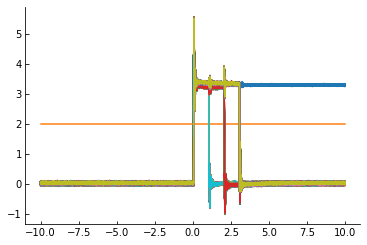

In [34]:
# show data
plot_multichannel(cam, [ch2, ch3, ch4], time_scale = 1_000_000)

In [35]:
# compute t0: the moment the camera exposure signal crosses the threshold
ind = get_delay_index(cam, 2)
t0 = cam[ind, 0]
print(f'Crossing time {t0} s, voltage(t0-1)={cam[ind-1,1]} and voltage(t0)={cam[ind,1]}')

Crossing time -1.5997694e-09 s, voltage(t0-1)=1.844 and voltage(t0)=2.008


In [36]:
# compute delay
delays_ch2 = (get_delays(ch2)-t0)*1_000_000_000  # to ns
print(f'1 us pulse: delay {np.mean(delays_ch2)} +/- {np.std(delays_ch2)} ns')
print(f'Min delay {np.min(delays_ch2)}, Median {np.median(delays_ch2)}, Max delay {np.max(delays_ch2)}\n')

# compute delay
delays_ch3 = (get_delays(ch3)-t0)*1_000_000_000  # to ns
print(f'2 us pulse: delay {np.mean(delays_ch3)} +/- {np.std(delays_ch3)} ns')
print(f'Min delay {np.min(delays_ch3)}, Median {np.median(delays_ch3)}, Max delay {np.max(delays_ch3)}\n')

# compute delay
delays_ch4 = (get_delays(ch4)-t0)*1_000_000_000  # to ns
print(f'3 us pulse: delay {np.mean(delays_ch4)} +/- {np.std(delays_ch4)} ns')
print(f'Min delay {np.min(delays_ch4)}, Median {np.median(delays_ch4)}, Max delay {np.max(delays_ch4)}')

1 us pulse: delay 66.0855957028846 +/- 0.13796233013559142 ns
Min delay 65.70559340000001, Median 66.08835440000001, Max delay 66.4933214

2 us pulse: delay 68.15750633627451 +/- 0.13894600448446512 ns
Min delay 67.8324154, Median 68.1544024, Max delay 68.54096240000001

3 us pulse: delay 60.28937799024391 +/- 0.13826782376140598 ns
Min delay 59.997560400000005, Median 60.2906204, Max delay 60.66023340000001


In [37]:
t_ch2 = get_pulse_length(ch2)
t_ch3 = get_pulse_length(ch3)
t_ch4 = get_pulse_length(ch4)

print(f'Pulse ch2 {np.mean(t_ch2)} +/- {np.std(t_ch2)} us')
print(f'Pulse ch3 {np.mean(t_ch3)} +/- {np.std(t_ch3)} us')
print(f'Pulse ch4 {np.mean(t_ch4)} +/- {np.std(t_ch4)} us')

Pulse ch2 0.9983615395625 +/- 0.00014696031447762126 us
Pulse ch3 1.9962490204166667 +/- 0.00019390068565855757 us
Pulse ch4 2.9987746353121953 +/- 0.00013155986212505806 us


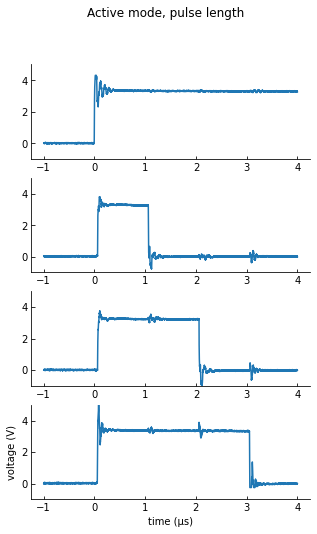

In [38]:
# plot figure panel b using the median
def plot_active_b(ref, v_list, xrange, time_scale = 1):
    '''
    Plot figure active panel b.
    '''
    tmin = xrange[0]
    tmax = xrange[1]
    rnge = [-1, 5]
    
    fig, ax = plt.subplots(len(v_list)+1, figsize=(5,8))
    ax[0].plot(ref[tmin:tmax,0]*time_scale,ref[tmin:tmax,1]) # camera
    ax[0].set_ylim(rnge)
    
    for i, v in enumerate(v_list):
        ax[i+1].plot(v[tmin:tmax,0]*time_scale,v[tmin:tmax,1]) # lasers 
        ax[i+1].set_ylim(rnge)
        
    fig.suptitle('Active mode, pulse length')
    ax[-1].set_xlabel(get_time(time_scale))
    ax[-1].set_ylabel('voltage (V)')
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_active_b.eps'), format='eps')

# get range -1 us to 4 us
tmin = np.argmax(cam[:,0] >= -1e-6)
tmax = np.argmax(cam[:,0] >= 4e-6)
    
# get the indices of the median delayed signals
i_ch2 = np.argmin(abs(delays_ch2 - np.median(delays)))
i_ch3 = np.argmin(abs(delays_ch3 - np.median(delays)))
i_ch4 = np.argmin(abs(delays_ch4 - np.median(delays)))

vals = [ch2[i_ch2],ch3[i_ch3],ch4[i_ch4]]

# plot the median delayed signals with the x-axis in us 
plot_active_b(cam, vals, [tmin, tmax], time_scale = 1_000_000)